# Integration of ZarrDataset with PyTorch's DataLoader (Advanced)

In [1]:
import zarrdataset as zds

import torch
from torch.utils.data import DataLoader, ChainDataset
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# These are images from the Image Data Resource (IDR) 
# https://idr.openmicroscopy.org/ that are publicly available and were 
# converted to the OME-NGFF (Zarr) format by the OME group. More examples
# can be found at Public OME-Zarr data (Nov. 2020)
# https://www.openmicroscopy.org/2020/11/04/zarr-data.html

filenames = [
    "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.1/6001240.zarr",
    "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.1/6001241.zarr",
    "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.1/6001242.zarr",
    "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.1/6001243.zarr",
]

### Extracting patches of size 128x128x32 `voxels` from a three-dimensional image

Sample the image randomly

In [3]:
patch_size = dict(Z=32, Y=128, X=128)
patch_sampler = zds.GridPatchSampler(patch_size=patch_size)

Transform the input data from uint16 to float16 with a torchvision pre-processing pipeline

In [4]:
import torchvision

img_preprocessing = torchvision.transforms.Compose([
    zds.ToDtype(dtype=np.float16)
])

Pass the pre-processing function to ZarrDataset to be used when generating the samples.

Also, enable return of each patch positions, and the worker ID that generated each patch. 

In [5]:
my_datasets = [zds.ZarrDataset(fn,
                               transform=img_preprocessing,
                               data_group="0",
                               source_axes="TCZYX",
                               patch_sampler=patch_sampler,
                               shuffle=True,
                               return_any_label=False,
                               return_positions=True,
                               return_worker_id=True)
              for fn in filenames]

### Create a ChainDataset from a set of ZarrDatasets that can be put together a single large dataset

In [6]:
my_chain_dataset = ChainDataset(my_datasets)

Make sure the chained_zarrdataset_worker_init function is passed to the DataLoader, so the workers can initialize the dataset correctly

In [7]:
my_dataloader = DataLoader(my_chain_dataset,
                           num_workers=2,
                           worker_init_fn=zds.chained_zarrdataset_worker_init,
                           batch_size=4
                           )

In [8]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [9]:
np.random.seed(478963)

In [11]:
samples = []
positions = []
wids = []
for i, (wid, pos, sample) in enumerate(my_dataloader):
    wids += [w for w in wid]
    positions += [p for p in pos]
    samples += [s for s in sample]    

    print(f"Sample {i+1} with size {sample.shape} extracted by worker {wid} from position {pos}")
    # print("-" * 10 + f" Difference={torch.sum(sample[0].float() - sample[1].float())}")

    if i > 3:
        # Take only five samples for illustration purposes
        break

samples = torch.cat(samples, dim=0)

Sample 1 with size torch.Size([4, 1, 2, 32, 128, 128]) extracted by worker tensor([0, 0, 0, 0]) from position tensor([[[  0,  -1],
         [  0,  -1],
         [  0,  32],
         [128, 256],
         [  0, 128]],

        [[  0,  -1],
         [  0,  -1],
         [192, 224],
         [  0, 128],
         [  0, 128]],

        [[  0,  -1],
         [  0,  -1],
         [ 32,  64],
         [  0, 128],
         [128, 256]],

        [[  0,  -1],
         [  0,  -1],
         [ 64,  96],
         [  0, 128],
         [128, 256]]])


RuntimeError: Caught RuntimeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "c:\Users\cervaf\Documents\Apps\miniconda3\envs\zds-dev\lib\site-packages\torch\utils\data\_utils\worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "c:\Users\cervaf\Documents\Apps\miniconda3\envs\zds-dev\lib\site-packages\torch\utils\data\_utils\fetch.py", line 40, in fetch
    return self.collate_fn(data)
  File "c:\Users\cervaf\Documents\Apps\miniconda3\envs\zds-dev\lib\site-packages\torch\utils\data\_utils\collate.py", line 175, in default_collate
    return [default_collate(samples) for samples in transposed]  # Backwards compatibility.
  File "c:\Users\cervaf\Documents\Apps\miniconda3\envs\zds-dev\lib\site-packages\torch\utils\data\_utils\collate.py", line 175, in <listcomp>
    return [default_collate(samples) for samples in transposed]  # Backwards compatibility.
  File "c:\Users\cervaf\Documents\Apps\miniconda3\envs\zds-dev\lib\site-packages\torch\utils\data\_utils\collate.py", line 149, in default_collate
    return default_collate([torch.as_tensor(b) for b in batch])
  File "c:\Users\cervaf\Documents\Apps\miniconda3\envs\zds-dev\lib\site-packages\torch\utils\data\_utils\collate.py", line 141, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [1, 2, 12, 128, 128] at entry 0 and [1, 2, 32, 128, 128] at entry 2


### Generate a grid with the sampled patches using `torchvision` utilities

In [ ]:
samples_grid = torchvision.utils.make_grid(samples[:, :, 0, ...])

(-0.5, 1041.5, 391.5, -0.5)

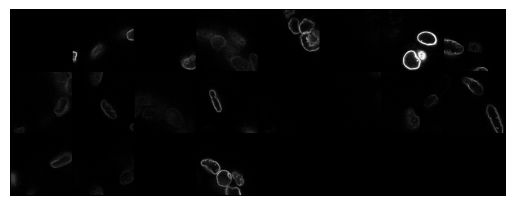

In [ ]:
plt.imshow(samples_grid[0], cmap="gray")
plt.axis('off')

(-0.5, 1041.5, 391.5, -0.5)

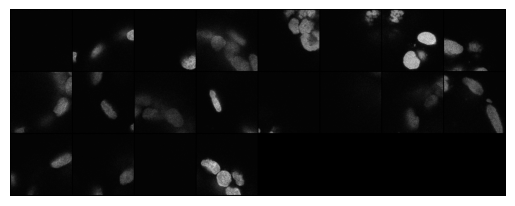

In [ ]:
plt.imshow(samples_grid[1], cmap="gray")
plt.axis('off')